# 用于手写数字识别的神经网络，多分类

在本练习中，您将使用神经网络来识别手写数字 0-9。


# 大纲
- [ 1 - 包 ](#1)
- [ 2 - ReLU 激活函数](#2)
- [ 3 - Softmax 函数](#3)
  - [ 练习 1](#ex01)
- [ 4 - 神经网络](#4)
  - [ 4.1 问题描述](#4.1)
  - [ 4.2 数据集](#4.2)
  - [ 4.3 模型表示](#4.3)
  - [ 4.4 Tensorflow 模型实现](#4.4)
  - [ 4.5 Softmax 放置](#4.5)
    - [ 练习 2](#ex02)


<a name="1"></a>
## 1 - 包

首先，让我们运行下面的单元格来导入在此任务期间需要的所有包。
- [numpy](https://numpy.org/) 是使用 Python 进行科学计算的基础包。
- [matplotlib](http://matplotlib.org) 是一个在 Python 中绘制图形的流行库。
- [tensorflow](https://www.tensorflow.org/) 是一个流行的机器学习平台。

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from public_tests import * 

from autils import *
from lab_utils_softmax import plt_softmax
np.set_printoptions(precision=2)

<a name="2"></a>
## 2 - ReLU 激活函数
本周，引入了一种新的激活函数，即 Rectified Linear Unit (ReLU). 
$$ a = max(0,z) \quad\quad\text {# ReLU function} $$

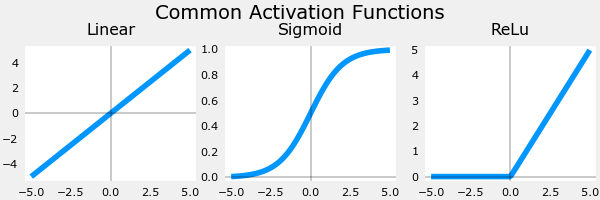

In [2]:
plt_act_trio()

<img align="right" src="./images/C2_W2_ReLu.png"     style=" width:380px; padding: 10px 20px; " >
右侧讲座中的示例显示了 ReLU 的应用。在此示例中，派生的“意识”特征不是二元的，而是具有连续范围的值。sigmoid 最适合开/关或二进制情况。ReLU 提供了一个连续的线性关系。
此外，它还有一个输出为零的“关闭”范围。“关闭”功能使 ReLU 成为非线性激活函数。
为什么需要这个？
这使得多个单元可以在不干扰的情况下对结果功能做出贡献。在支持的可选实验室中对此进行了更多检查。

<a name="3"></a>
## 3 - Softmax 函数
多类神经网络生成 N 个输出。选择一个输出作为预测答案。在输出层，一个向量 $\mathbf{z}$ 由一个线性函数生成，该线性函数被输入到一个 softmax 函数中。
softmax 函数将 $\mathbf{z}$ 转换为如下所述的概率分布。应用 softmax 后，每个输出将介于 0 和 1 之间，并且输出总和为 1。它们可以解释为概率。softmax 的较大输入将对应较大的输出概率。

<center>  <img  src="./images/C2_W2_NNSoftmax.PNG" width="600" />  

softmax函数可以写成：
$$a_j = \frac{e^{z_j}}{ \sum_{k=0}^{N-1}{e^{z_k} }} \tag{1}$$

其中 $z = \mathbf{w} \cdot \mathbf{x} + b$ 和 N 是输出层中特征/类别的数量。

<a name="ex01"></a>
### 练习 1
让我们创建一个 NumPy 实现：

In [3]:
# UNQ_C1
# GRADED CELL: my_softmax

def my_softmax(z):  
    """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """    
    ### START CODE HERE ### 
    a = np.exp(z)/np.exp(z).sum()
    ### END CODE HERE ### 
    return a

In [4]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)
print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")

# BEGIN UNIT TEST  
test_my_softmax(my_softmax)
# END UNIT TEST  

my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]
 All tests passed.


下面，改变 `z` 输入的值。特别注意分子中的指数如何放大值的微小差异。另请注意，输出值总和为 1。

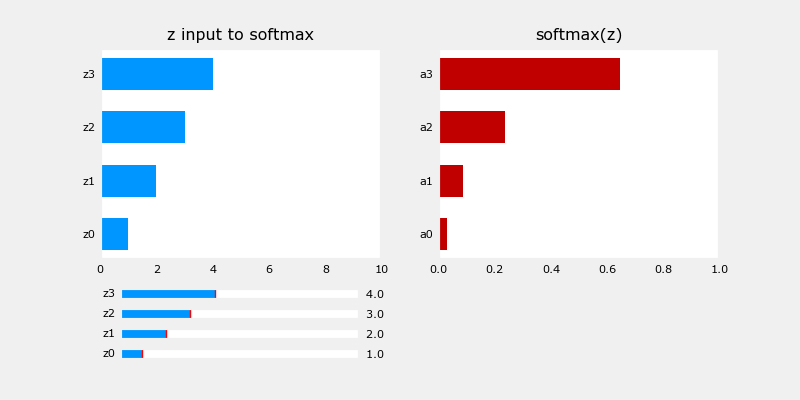

In [5]:
plt.close("all")
plt_softmax(my_softmax)

<a name="4"></a>
## 4 - 神经网络

在上周的作业中，您实现了一个神经网络来进行二元分类。本周您将把它扩展到多类分类。这将利用 softmax 函数。

<a name="4.1"></a>
### 4.1 问题描述

在本练习中，您将使用神经网络识别十个手写数字（0-9）。这是一个多类分类任务，其中选择了 n 个选项之一。自动手写数字识别如今已广泛使用——从识别邮件信封上的邮政编码（postal code）到识别银行支票上的金额。


<a name="4.2"></a>
### 4.2 数据集

首先，您将为此任务加载数据集。
- 如下所示， `load_data()` 函数将数据加载到变量 `X` 和 `y`


- 该数据集包含 5000 个手写数字 $^1$ 的训练示例。

    - 每个训练示例都是数字的 20 像素 x 20 像素灰度图像。
        - 每个像素由一个浮点数表示，表示该位置的灰度强度。
        - 20 x 20 像素网格被“展开”成一个 400 维向量。
        - 每个训练示例都成为我们数据矩阵 `X` 中的一行。
        - 这为我们提供了一个 5000 x 400 矩阵 `X` ，其中每一行都是手写数字图像的训练示例。

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- 训练集的第二部分是一个 5000 x 1 维向量 `y` ，其中包含训练集的标签
    - 如果图像是数字 `0`，`y = 0`,如果图像是数字 `4`, `y = 4` 等等。

$^1$<sub> 这是MNIST手写数字数据集的一个子集 (http://yann.lecun.com/exdb/mnist/)</sub>

In [6]:
# load dataset
X, y = load_data()

#### 4.2.1 查看变量
让我们更熟悉您的数据集。
- 一个好的开始是打印出每个变量并查看它包含的内容。

下面的代码打印变量 `X` 和 `y` 中的第一个元素。

In [7]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [8]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


#### 4.2.2 检查变量的维度

熟悉数据的另一种方法是查看其维度。请打印 `X` 和 `y` 的形状，看看你的数据集中有多少训练样例。

In [9]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


#### 4.2.3 可视化数据

您将从可视化训练集的子集开始。
- 在下面的单元格中，代码从 `x` 中随机选择 64 行，将每行映射回 20 x 20 像素的灰度图像，并将图像一起显示。
- 每个图像的标签显示在图像上方

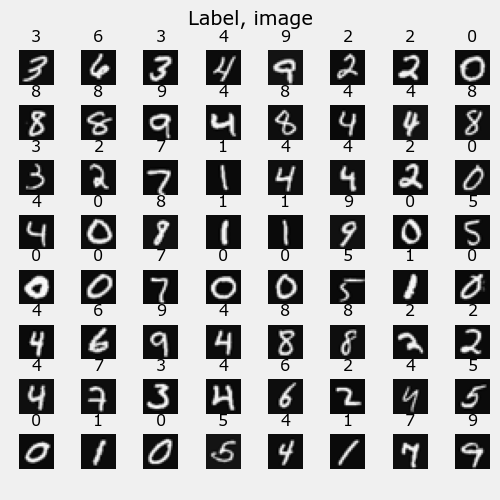

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

<a name="4.3"></a>
### 4.3 模型表示

您将在此作业中使用的神经网络如下图所示。
- 这有两个具有 ReLU 激活函数的稠密层，然后是具有线性激活函数的输出层。
    - 回想一下，我们的输入是数字图像的像素值。
    - 由于图像的大小为 $20\times20$，这给了我们 $400$ 的输入
    
<img src="images/C2_W2_Assigment_NN.png" width="600" height="450">

- 这些参数的尺寸用于神经网络，在第1层为$25$单位，在第2层为$15$单位，在第3层为$10$输出单位，每个单位都对应一个数字。

    - 回想一下，这些参数的维度确定如下：
        - 如果网络在一层有 $s_{in}$ 个单元，在下一层有 $s_{out}$ 个单元，那么
            - $W$ 的维度为 $s_{in} \times s_{out}$。
            - $b$ 将是一个带有 $s_{out}$ 个元素的向量
  
    - 因此， `W` 和 `b` 的形状为： 
        - layer1：`W1`的形状是(400, 25)，`b1`的形状是(25,)
        - layer2：`W2`的形状是(25, 15)，`b2`的形状是：(15,)
        - layer3：`W3`的形状是(15, 10)，`b3`的形状是：(10,)
>**注意:** 偏置向量 `b` 可以表示为一维 (n,) 或二维 (n,1) 数组。Tensorflow 使用一维表示，本实验室将保持该约定：
               

<a name="4.4"></a>
### 4.4 Tensorflow 模型实现


TensorFlow 模型是逐层构建的。为您计算图层的输入尺寸(上面的 $s_{in}$)。您指定一个层的*输出尺寸*，这将确定下一层的输入尺寸。第一层的输入维度来源于下面的`model.fit`语句中指定的输入数据的大小。
>**注意:** 也可以添加一个输入层，指定第一层的输入维度。例如：
`tf.keras.Input(shape=(400,)),    #specify input shape`  
我们将在此处阐明一些模型尺寸。

<a name="4.5"></a>
### 4.5 Softmax 放置
如讲座和可选的 softmax 实验室中所述，如果在训练期间将 softmax 与损失函数而不是输出层分组，则数值稳定性会得到提高。这在*构建*模型和*使用*模型时会产生影响。

构建模型:  
* 最后的密集层应该使用“线性”激活函数。实际上没有激活函数。
* `model.compile` 语句将通过包含 `from_logits=True` 来表明这一点。
`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) `  
* 这不会影响目标的形式。在稀疏分类交叉熵的情况下，目标是预期的数字，0-9。

使用模型:
* 输出不是概率。如果需要输出概率，请使用 softmax 函数。

<a name="ex02"></a>
### 练习 2
下面，使用带有ReLU激活函数的 Keras [Sequential model](https://keras.io/guides/sequential_model/) 和 [Dense Layer](https://keras.io/api/layers/core_layers/dense/) 构建上述三层网络。

In [11]:
# UNQ_C2
# GRADED CELL: Sequential model
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        ### START CODE HERE ### 
        tf.keras.Input(shape=(400,)),
        Dense(25, activation='relu', name = 'layer1'),
        Dense(15, activation='relu', name = 'layer2'),
        Dense(10, activation='linear', name = 'layer3'),
        ### END CODE HERE ### 
    ], name = "my_model" 
)

In [12]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 25)                10025     
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 10)                160       
                                                                 
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________


<details>
  <summary><font size="3" color="darkgreen"><b>预期输出（点击展开）</b></font></summary>
The `model.summary()` function displays a useful summary of the model. Note, the names of the layers may vary as they are auto-generated unless the name is specified.    
    
```
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 25)                10025     
_________________________________________________________________
L2 (Dense)                   (None, 15)                390       
_________________________________________________________________
L3 (Dense)                   (None, 10)                160       
=================================================================
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________
```

In [13]:
# BEGIN UNIT TEST     
test_model(model, 10, 400)
# END UNIT TEST     

All tests passed!


摘要中显示的参数计数对应于权重和偏差数组中的元素数量，如下所示。

让我们进一步检查权重，以验证 tensorflow 产生的维度与我们上面计算的相同。

In [14]:
[layer1, layer2, layer3] = model.layers

In [15]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


**预期输出**
```
W1 shape = (400, 25), b1 shape = (25,)  
W2 shape = (25, 15), b2 shape = (15,)  
W3 shape = (15, 10), b3 shape = (10,)
```

以下代码：
* 定义了一个损失函数, `SparseCategoricalCrossentropy` ，通过添加 `from_logits=True` ，指定 softmax 应包含在损失计算中
* 定义一个优化器。一个流行的选择是在讲座中描述的 Adaptive Moment (Adam)。

In [16]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 [==============================] - 1s 1ms/step - loss: 1.7094
Epoch 2/40
157/157 [==============================] - 0s 1ms/step - loss: 0.7480
Epoch 3/40
157/157 [==============================] - 0s 1ms/step - loss: 0.4428
Epoch 4/40
157/157 [==============================] - 0s 1ms/step - loss: 0.3463
Epoch 5/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2977
Epoch 6/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2630
Epoch 7/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2361
Epoch 8/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2131
Epoch 9/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2004
Epoch 10/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1805
Epoch 11/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1692
Epoch 12/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1580
Epoch 13/40
157/157 [====

#### epoch和批次
在上面的 `compile` 语句中，`epochs` 的数量设置为 100。这指定在训练期间应应用整个数据集 100 次。在训练期间，您会看到描述训练进度的输出，如下所示：
```
Epoch 1/100
157/157 [==============================] - 0s 1ms/step - loss: 2.2770
```
第一行，`Epoch 1/100`，描述了模型当前正在运行的 epoch。为了提高效率，训练数据集被分成“批次”。Tensorflow 中批次的默认大小为 32。我们的数据集中有 5000 个示例，大约 157 个批次。第 2 行 `157/157 [====` 上的符号描述了已执行的批处理。

#### 损失
在课程 1 中，我们学会了通过监控损失来跟踪梯度下降的进度。理想情况下，损失会随着算法迭代次数的增加而降低。TensorFlow 将损失称为'loss'。在上面，您看到每个 epoch 的损失都显示为 `model.fit` 正在执行。[.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model) 方法返回包括损失在内的各种指标。这是在上面的 `history` 变量中捕获的。这可用于检查图中的损失，如下所示。

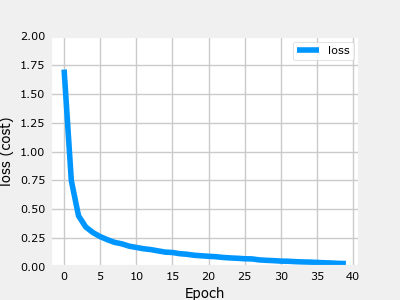

In [17]:
plot_loss_tf(history)

#### 预测
要进行预测，请使用 Keras `predict`。下面，X[1015] 包含一个2的图像。

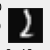

1/1 [==============================] - 0s 50ms/step
 predicting a Two: 
[[ -7.99  -2.23   0.77  -2.41 -11.66 -11.15  -9.53  -3.36  -4.42  -7.17]]
 Largest Prediction index: 2


In [18]:
image_of_two = X[1015]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))  # prediction

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

最大的输出是预测[2]，表示预测的数字是'2'。如果问题只需要选择，那就足够了。使用 NumPy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) 来选择它。如果问题需要概率，则需要softmax：

In [19]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[1.42e-04 4.49e-02 8.98e-01 3.76e-02 3.61e-06 5.97e-06 3.03e-05 1.44e-02
  5.03e-03 3.22e-04]]
Total of predictions: 1.000


要返回一个表示预测目标的整数，您需要最大概率的索引。这是通过 Numpy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) 函数完成的

In [20]:
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


让我们比较 64 位随机样本的预测和标签。这需要一点时间来运行。

1/1 [==============================] - 0s 18ms/step


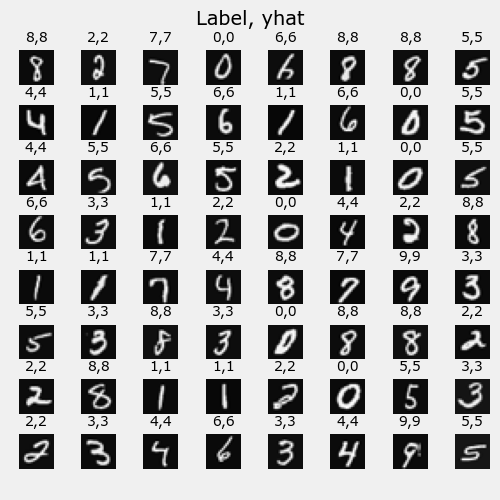

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

让我们看看其中的一些错误。
>注意: 增加训练 epoch 的数量可以消除该数据集上的错误。

1/1 [==============================] - 0s 17ms/step
15 errors out of 5000 images


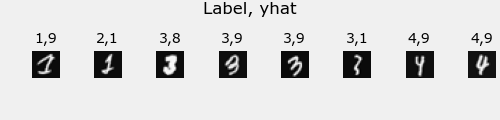

In [22]:
print( f"{display_errors(model,X,y)} errors out of {len(X)} images")

### 恭喜！
您已成功构建并利用神经网络进行多类分类。